In [1]:
import os
import numpy as np
import random
import h5py
import sys
from decimal import Decimal
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import UpSampling2D, Cropping2D
from keras import models
from sklearn.metrics import accuracy_score
import warnings
     

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
warnings.filterwarnings("ignore")

**BadNets**
It shows the original badnet and it will print out the accuracy and attack success rate for the original badnet

In [4]:
clean_data_filename = '/content/drive/MyDrive/lab3/data/cl/valid.h5'
poisoned_data_filename = '/content/drive/MyDrive/lab3/data/bd/bd_valid.h5'
model_filename = '/content/drive/MyDrive/lab3/models/bd_net.h5'

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def main():
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    bd_model = keras.models.load_model(model_filename)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()

361/361 [==============================] - 8s 2ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 1s 2ms/step
Attack Success Rate: 100.0


**Seeing the model structure**

In [5]:

model = keras.models.load_model(model_filename)

In [6]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [7]:
x_data, y_data = data_loader(clean_data_filename)

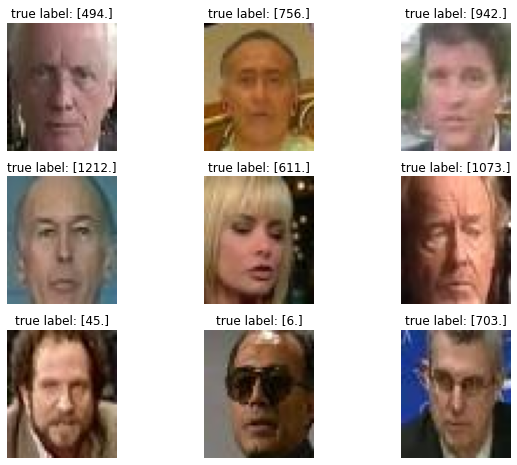

In [8]:

figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [9]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filename)

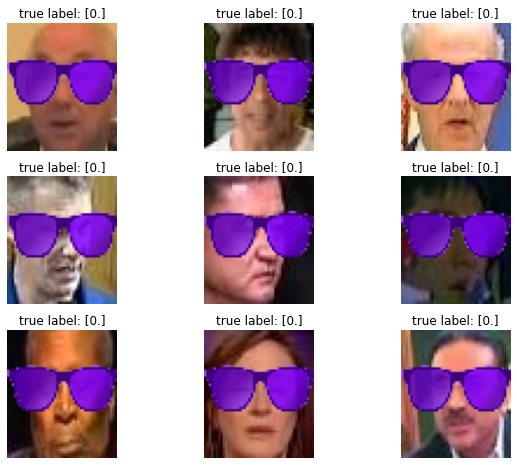

In [10]:

figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [11]:
# clearing the session
keras.backend.clear_session()

# **Prune defense**



In [12]:
# getting the data
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

In [13]:
from tqdm import tqdm
clean_data_acc = 98.64899974019225
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights()) 
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

# getting the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)  
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq): 
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()


361/361 [==============================] - 1s 2ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 2ms/step


  2%|▏         | 1/60 [00:02<02:48,  2.86s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26


  3%|▎         | 2/60 [00:05<02:44,  2.84s/it]

361/361 [==============================] - 1s 2ms/step


  5%|▌         | 3/60 [00:08<02:32,  2.68s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30


  7%|▋         | 4/60 [00:10<02:25,  2.59s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31


  8%|▊         | 5/60 [00:13<02:26,  2.67s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is: 

 10%|█         | 6/60 [00:15<02:20,  2.61s/it]

 98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
361/361 [==============================] - 1s 2ms/step


 12%|█▏        | 7/60 [00:18<02:16,  2.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34
361/361 [==============================] - 1s 2ms/step


 13%|█▎        | 8/60 [00:21<02:14,  2.59s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37


 15%|█▌        | 9/60 [00:23<02:10,  2.56s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38


 17%|█▋        | 10/60 [00:26<02:06,  2.54s/it]

361/361 [==============================] - 1s 2ms/step


 18%|█▊        | 11/60 [00:28<02:06,  2.58s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39


 20%|██        | 12/60 [00:31<02:04,  2.60s/it]

361/361 [==============================] - 1s 2ms/step


 22%|██▏       | 13/60 [00:33<02:00,  2.56s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 1s 2ms/step


 23%|██▎       | 14/60 [00:36<01:56,  2.53s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  

 25%|██▌       | 15/60 [00:38<01:53,  2.51s/it]

45
361/361 [==============================] - 1s 2ms/step


 27%|██▋       | 16/60 [00:41<01:50,  2.50s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
361/361 [==============================] - 1s 2ms/step


 28%|██▊       | 17/60 [00:43<01:49,  2.55s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 1s 2ms/step


 30%|███       | 18/60 [00:46<01:46,  2.55s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 1s 2ms/step


 32%|███▏      | 19/60 [00:48<01:43,  2.53s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50
361/361 [==============================] - 1s 2ms/step


 33%|███▎      | 20/60 [00:51<01:42,  2.56s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
361/361 [==============================] - 1s 2ms/step


 35%|███▌      | 21/60 [00:54<01:39,  2.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 1s 2ms/step


 37%|███▋      | 22/60 [00:56<01:35,  2.53s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
361/361 [==============================] - 1s 2ms/step


 38%|███▊      | 23/60 [00:59<01:34,  2.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24
361/361 [==============================] - 1s 2ms/step


 40%|████      | 24/60 [01:01<01:31,  2.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 1s 2ms/step


 42%|████▏     | 25/60 [01:04<01:28,  2.53s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
361/361 [==============================] - 1s 2ms/step


 43%|████▎     | 26/60 [01:06<01:27,  2.56s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
361/361 [==============================] - 1s 2ms/step


 45%|████▌     | 27/60 [01:09<01:23,  2.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 1s 2ms/step


 47%|████▋     | 28/60 [01:11<01:20,  2.53s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 1s 2ms/step


 48%|████▊     | 29/60 [01:14<01:19,  2.56s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 1s 2ms/step


 50%|█████     | 30/60 [01:16<01:16,  2.55s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
361/361 [==============================] - 1s 2ms/step


 52%|█████▏    | 31/60 [01:19<01:13,  2.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 1s 2ms/step


 53%|█████▎    | 32/60 [01:22<01:11,  2.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 1s 2ms/step


 55%|█████▌    | 33/60 [01:24<01:08,  2.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51


 57%|█████▋    | 34/60 [01:27<01:05,  2.53s/it]

361/361 [==============================] - 1s 2ms/step


 58%|█████▊    | 35/60 [01:29<01:04,  2.58s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 1s 2ms/step


 60%|██████    | 36/60 [01:32<01:01,  2.55s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
361/361 [==============================] - 1s 2ms/step


 62%|██████▏   | 37/60 [01:34<00:58,  2.53s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20


 63%|██████▎   | 38/60 [01:37<00:56,  2.56s/it]

361/361 [==============================] - 1s 2ms/step


 65%|██████▌   | 39/60 [01:39<00:53,  2.54s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 1s 2ms/step


 67%|██████▋   | 40/60 [01:42<00:50,  2.52s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58


 68%|██████▊   | 41/60 [01:45<00:48,  2.55s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3


 70%|███████   | 42/60 [01:47<00:46,  2.57s/it]

361/361 [==============================] - 1s 2ms/step


 72%|███████▏  | 43/60 [01:50<00:43,  2.55s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 1s 2ms/step


 73%|███████▎  | 44/60 [01:52<00:41,  2.62s/it]


The clean accuracy is:  97.51450593227679
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 1s 2ms/step


The accuracy drops at least 2%, saved the model
361/361 [==============================] - 1s 2ms/step


 75%|███████▌  | 45/60 [01:55<00:38,  2.59s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 1s 2ms/step


 77%|███████▋  | 46/60 [01:57<00:35,  2.56s/it]


The clean accuracy is:  95.21087728414307
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 1s 2ms/step


 78%|███████▊  | 47/60 [02:00<00:33,  2.60s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 1s 2ms/step


The accuracy drops at least 4%, saved the model
361/361 [==============================] - 1s 2ms/step


 80%|████████  | 48/60 [02:03<00:31,  2.63s/it]


The clean accuracy is:  92.10184463497012
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 1s 2ms/step


 82%|████████▏ | 49/60 [02:05<00:28,  2.60s/it]


The clean accuracy is:  91.48696631159609
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
361/361 [==============================] - 1s 2ms/step


 83%|████████▎ | 50/60 [02:08<00:25,  2.57s/it]


The clean accuracy is:  91.02797263358448
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 1s 2ms/step


 85%|████████▌ | 51/60 [02:10<00:22,  2.55s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.78288733004243
The pruned channel index is:  11
361/361 [==============================] - 1s 2ms/step


The accuracy drops at least 10%, saved the model
361/361 [==============================] - 1s 2ms/step


 87%|████████▋ | 52/60 [02:13<00:20,  2.55s/it]


The clean accuracy is:  84.45483675413527
The attack success rate is:  77.03299558326839
The pruned channel index is:  54
361/361 [==============================] - 1s 2ms/step


 88%|████████▊ | 53/60 [02:16<00:18,  2.58s/it]


The clean accuracy is:  76.47007880834849
The attack success rate is:  35.73222482029965
The pruned channel index is:  10
361/361 [==============================] - 1s 2ms/step


 90%|█████████ | 54/60 [02:18<00:15,  2.55s/it]


The clean accuracy is:  54.83675413527324
The attack success rate is:  6.980168009006668
The pruned channel index is:  28
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  27.080627002684682
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35


 92%|█████████▏| 55/60 [02:21<00:12,  2.54s/it]

361/361 [==============================] - 1s 2ms/step


 93%|█████████▎| 56/60 [02:23<00:10,  2.57s/it]


The clean accuracy is:  13.882393695332121
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 1s 2ms/step

The clean accuracy is: 

 95%|█████████▌| 57/60 [02:26<00:07,  2.54s/it]

 7.092751363990647
The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 1s 2ms/step


 97%|█████████▋| 58/60 [02:28<00:05,  2.53s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 1s 2ms/step


 98%|█████████▊| 59/60 [02:31<00:02,  2.57s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 1s 2ms/step


100%|██████████| 60/60 [02:33<00:00,  2.56s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


In [14]:
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.51450593227679, 95.75647354291158, 95.21087728414307, 94.7172425738287, 92.10184463497012, 91.48696631159609, 91.02797263358448, 89.17467740538669, 84.454836754135

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

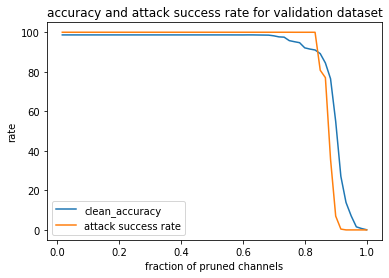

In [15]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [16]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.980168009006668


Combining the models
Here we combine two models which are $B$ (original badnet model) and $B'$ (pruned model). The combined model is the goodnet. If the preditions from $B$ and $B'$ are the same then the goodnet will output the predition. 

In [17]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

**Evaluate the combined model**

In [21]:
test_data_filename = '/content/drive/MyDrive/lab3/data/cl/test.h5'
poisoned_test_data_filename = '/content/drive/MyDrive/lab3/data/bd/bd_test.h5'
test_model_X_2_filename = '/content/model_X=2.h5'
test_model_X_4_filename = '/content/model_X=4.h5'
test_model_X_10_filename = '/content/model_X=10.h5'

In [19]:

test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [22]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

In [23]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [24]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

Evaluating on the test dataset

In [25]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model, Attack Success Rate:', asr_2)

cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model, Attack Success Rate:', asr_4)

cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model, Attack Success Rate:', asr_10)

401/401 [==============================] - 1s 2ms/step
2% drops model, the clean test data Classification accuracy: 95.90802805923616
401/401 [==============================] - 1s 2ms/step
2% drops model, Attack Success Rate: 100.0
401/401 [==============================] - 1s 2ms/step
4% drops model, the clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 1s 2ms/step
4% drops model, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 1s 2ms/step
10% drops model, the clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 1s 2ms/step
10% drops model, Attack Success Rate: 77.23304754481684


Summarizing the fixed models

In [27]:
import pandas as pd
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.908028,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.233048


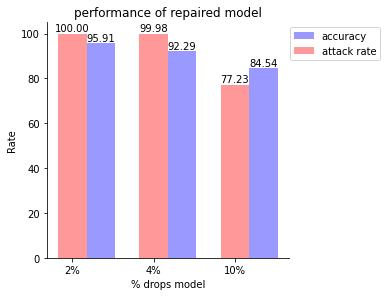

In [29]:
import seaborn as sns
opacity = 0.4
bar_width = 0.35

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()
     

In [30]:

G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)

Combined 2% drops model, the clean test data Classification accuracy: 95.90802805923616
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.23304754481684


In [31]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.908028,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.233048


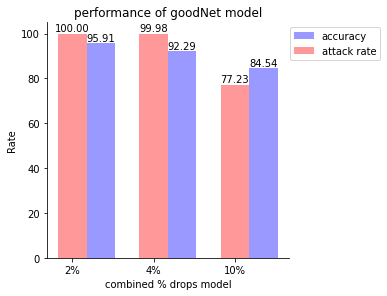

In [32]:

opacity = 0.4
bar_width = 0.35

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()
